In [254]:
import datetime
import os
import json
from datetime import timezone
from typing import TypedDict, Annotated, List
import operator

from dotenv import load_dotenv;
from pydantic import  BaseModel, Field

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build



from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

from IPython.display import Image, display

In [255]:
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY") 

if not all([groq_api_key, tavily_api_key]):
    raise ValueError("One or more required API keys (GROQ, TAVILY) are missing from the .env file!")


llm = ChatGroq(model="llama3-70b-8192", api_key=groq_api_key, temperature=0)
print("Groq LLM (Llama3-70b) configured and ready.")

Groq LLM (Llama3-70b) configured and ready.


In [257]:
class CalendarEvent(BaseModel):
    """Schema for a single calendar event."""
    summary: str = Field(description="The title or summary of the calendar event.")
    start_time: str = Field(description="The start time of the event in ISO format.")
    source: str = Field(description="The source of the calendar, either 'Google' or 'Apple'.")


def _fetch_google_events() -> List[dict]:
    """Internal function to fetch events from Google Calendar."""
    creds = None
    if os.path.exists("token.json"):
        creds = Credentials.from_authorized_user_file("token.json", ["https://www.googleapis.com/auth/calendar.readonly"])
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file("credentials.json", ["https://www.googleapis.com/auth/calendar.readonly"])
            creds = flow.run_local_server(port=0)
        with open("token.json", "w") as token:
            token.write(creds.to_json())

    try:
        service = build("calendar", "v3", credentials=creds)
        now_utc = datetime.datetime.now(timezone.utc).isoformat()
        events_result = service.events().list(
            calendarId="primary", timeMin=now_utc, maxResults=15, singleEvents=True, orderBy="startTime"
        ).execute()
        events = events_result.get("items", [])
        
        if not events: return []

        output_events = []
        for event in events:
            start = event["start"].get("dateTime", event["start"].get("date"))
            event_model = CalendarEvent(summary=event.get("summary", "No Title"), start_time=start, source="Google")
            output_events.append(event_model.model_dump())
        return output_events
    except Exception as e:
        return [{"error": f"An error occurred with Google Calendar: {e}"}]

In [258]:
@tool
def check_google_calendar() -> List[dict]:
    """
    Checks the user's primary Google Calendar for the next 15 upcoming events.
    Use this function when the user asks about their schedule, appointments, or meetings.
    """
    print("--- Tool: check_google_calendar called by agent ---")
    
    google_events = _fetch_google_events()
    
    if not google_events:
        return [{"message": "No upcoming events found in your Google Calendar."}]

    def get_datetime_for_sorting(event):
        """A robust key for sorting events that can be either date or datetime."""
        time_str = event.get('start_time', '')
        try:
            if 'T' in time_str:
                return datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00'))
            else:
                return datetime.datetime.fromisoformat(time_str)
        except (ValueError, TypeError):
            return datetime.datetime.max

    valid_events = [e for e in google_events if 'error' not in e]
    valid_events.sort(key=get_datetime_for_sorting)
    
    return valid_events



@tool
def tavily_search(query: str) -> str:
    """
    A search engine tool. Use this for questions about real-time events, facts, or general knowledge.
    Do NOT use this for questions about the user's personal calendar or schedule.
    """
    print(f"--- Tool: tavily_search called with query: '{query}' ---")
    try:
        search = TavilySearch(max_results=3, api_key=tavily_api_key)
        results_str = search.invoke(query)
        
        if not results_str:
            return "No results found from web search."
        
        return results_str
        
    except Exception as e:
        print(f"!!! TAVILY SEARCH FAILED: {e}")
        return f"Error occurred during web search: {e}"


tools = [check_google_calendar, tavily_search]
print(f"Defined {len(tools)} tools for the agent: {[t.name for t in tools]}")

Defined 2 tools for the agent: ['check_google_calendar', 'tavily_search']


In [259]:
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]


llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools)


def agent_node(state):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


def should_continue(state):
    if state["messages"][-1].tool_calls:
        return "tools"
    return END

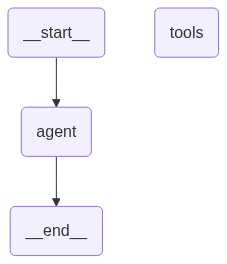

In [260]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
system_prompt = """
You are a multi-talented personal assistant.

Your capabilities are:
1.  **General Conversation:** You can chat about any topic, tell jokes, or answer general questions. For factual questions, use your `tavily_search` tool.
2.  **Calendar Management:** You can check the user's Google Calendar for upcoming events using the `check_google_calendar` tool.

**Core Instructions:**

1.  **Analyze Intent:** First, determine if the user is asking a question that requires external data from a tool, or if they are just having a conversation.

2.  **Use Tools ONLY When Necessary:** You have tools to check the calendar (`check_google_calendar`) and search the web (`tavily_search`). You MUST ONLY use the calendar tool if the user's latest message specifically asks about their schedule, appointments, or meetings.

3.  **Handle Social Cues (IMPORTANT):** If you have just provided information from a tool and the user responds with a simple social courtesy like "Thank you", "Okay", "Got it", "Thanks", or "Perfect", DO NOT use any tools again. Your task is to provide a polite, conversational reply.

4.  **Prioritize Natural Conversation:** If a tool is not strictly required, always prefer to respond naturally as a conversational AI.
"""

messages = [SystemMessage(content=system_prompt)]

print("Your assistant is ready. You can now start chatting.")
print("   Type 'quit' or 'exit' to end the conversation.")
print("-" * 50) 

while True:
    user_input = input("You: ")
    if user_input.lower() in ["quit", "exit"]:
        print("Assistant: Goodbye!")
        break


    print(f"You: {user_input}")

    messages.append(HumanMessage(content=user_input))

    state = {"messages": messages}
    
    final_state = app.invoke(state)

    final_response = final_state["messages"][-1]
    messages.append(final_response)

    print(f"Assistant: {final_response.content}")